# 人脸生成

### 获取数据
使用如下两种数据集:
- MNIST
- CelebA

由于celebA数据集相对比较复杂，先用MNIST数据集测试生成对抗神经网络的性能，然后再将模型在celebA数据集上运行。


In [2]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 认识数据
### MNIST

MNIST数据集包含手写字图片

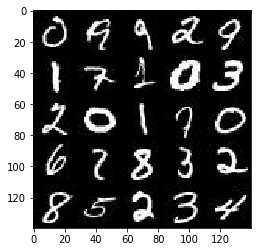

In [3]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA

[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)数据集包含超过200,000幅名人图像。

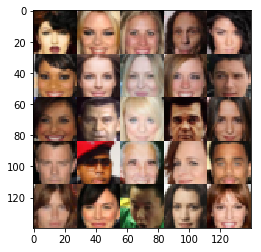

In [4]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 数据预处理

将MNIST数据集和CelebA数据集中图像的大小处理成28×28，像素值调整到-0.5到0.5之间。CelebA数据集将移除不包括一张人脸的部分。
MNIST数据集是灰度图像，只有一个颜色通道，CelebA数据集是彩色图像，包含三个颜色通道。

## 构建神经网络
构建GANs需要如下几个部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`


In [2]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


### Input
为神经网络创建placeholder


In [3]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name = 'input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name = 'input_z')
    lr = tf.placeholder(tf.float32,name = 'lr')

    return (input_real,input_z,lr)
    

### Discriminator



In [4]:
def discriminator(images, reuse=False):

    alpha = 0.2
    with tf.variable_scope('discriminator',reuse = reuse):
        #input 28*28*3         
        x1 = tf.layers.conv2d(images,64,5,strides = 2,padding = 'same')
        relu1 = tf.maximum(alpha*x1,x1)
        #14*14*64         
        
        x2 = tf.layers.conv2d(relu1,128,4,strides = 2,padding = 'same')
        bn2 = tf.layers.batch_normalization(x2,training = True)
        relu2 = tf.maximum(alpha*bn2,bn2)
        #7*7*128         
        
        x3 = tf.layers.conv2d(relu2,256,5,strides = 1,padding = 'same')
        bn3 = tf.layers.batch_normalization(x3,training = True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        #7*7*256         

        flat = tf.reshape(relu3,(-1,7*7*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return (out,logits)
    


### Generator
生成器返回28×28的图像

In [5]:
def generator(z, out_channel_dim, is_train=True):

    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator',reuse = reuse):
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training = is_train)
        x1 = tf.maximum(alpha*x1,x1)
       #7*7*512         
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides = 1,padding = 'same')
        x2 = tf.layers.batch_normalization(x2,training = is_train)
        x2 = tf.maximum(alpha*x2,x2)
       #7*7*256         
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides = 2,padding = 'same')
        x3 = tf.layers.batch_normalization(x3,training = is_train)
        x3 = tf.maximum(alpha*x3,x3)
       #14*14*128         
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides = 2,padding = 'same')
        out = tf.tanh(logits)
       #28*28*3         
    
    return out


### Loss
用于训练GANs，分别返回discriminator损失和generator损失。

In [6]:
def model_loss(input_real, input_z, out_channel_dim):

    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse = True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss,g_loss)


### Optimization

In [7]:
def model_opt(d_loss, g_loss, learning_rate, beta1):

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1 = beta1).minimize(d_loss,var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1 = beta1).minimize(g_loss,var_list = g_vars)
    
    return (d_train_opt,g_train_opt)


## 训练神经网络


In [11]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [8]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):


    (_, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = 2.0 * batch_images
                

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

                
                

### MNIST


Epoch 1/2... Discriminator Loss: 0.7724... Generator Loss: 7.2152
Epoch 1/2... Discriminator Loss: 7.5171... Generator Loss: 0.0071
Epoch 1/2... Discriminator Loss: 4.5550... Generator Loss: 0.0316
Epoch 1/2... Discriminator Loss: 3.0968... Generator Loss: 0.2522
Epoch 1/2... Discriminator Loss: 4.0449... Generator Loss: 0.0476
Epoch 1/2... Discriminator Loss: 2.7772... Generator Loss: 0.1457
Epoch 1/2... Discriminator Loss: 2.8394... Generator Loss: 0.1329
Epoch 1/2... Discriminator Loss: 1.8877... Generator Loss: 0.3846
Epoch 1/2... Discriminator Loss: 2.5139... Generator Loss: 0.1716
Epoch 1/2... Discriminator Loss: 2.7724... Generator Loss: 0.1592


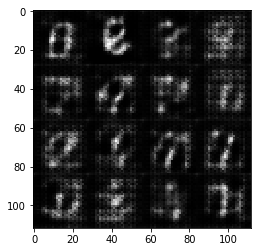

Epoch 1/2... Discriminator Loss: 2.2859... Generator Loss: 0.1605
Epoch 1/2... Discriminator Loss: 2.7033... Generator Loss: 0.1412
Epoch 1/2... Discriminator Loss: 2.3840... Generator Loss: 0.5637
Epoch 1/2... Discriminator Loss: 1.9591... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 1.7028... Generator Loss: 0.2827
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 2.0347... Generator Loss: 0.3159
Epoch 1/2... Discriminator Loss: 2.2509... Generator Loss: 0.2246
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 0.3395
Epoch 1/2... Discriminator Loss: 1.8323... Generator Loss: 0.3389


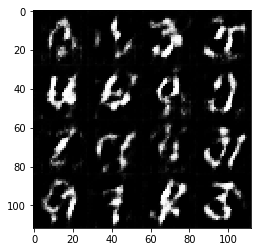

Epoch 1/2... Discriminator Loss: 1.8113... Generator Loss: 1.0689
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 1.0951
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 1.4939... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 2.0506... Generator Loss: 2.0227
Epoch 1/2... Discriminator Loss: 1.6000... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 2.1198... Generator Loss: 0.2408
Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.2695
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 1.5148


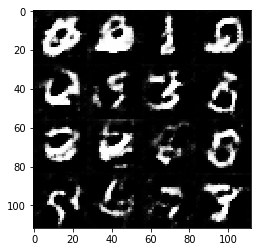

Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 1.2379
Epoch 1/2... Discriminator Loss: 1.5862... Generator Loss: 1.4188
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.7229... Generator Loss: 0.2974
Epoch 1/2... Discriminator Loss: 1.5450... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 1.5390... Generator Loss: 0.3035
Epoch 1/2... Discriminator Loss: 1.5718... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.7082... Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 1.5154


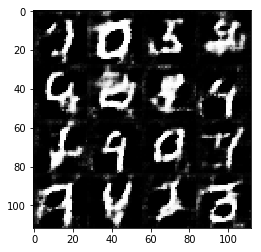

Epoch 1/2... Discriminator Loss: 1.6955... Generator Loss: 0.2861
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 1.7133... Generator Loss: 0.2911
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.4394... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 1.5291... Generator Loss: 1.4735
Epoch 1/2... Discriminator Loss: 1.7094... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.4818
Epoch 1/2... Discriminator Loss: 1.6734... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.6623... Generator Loss: 0.3270


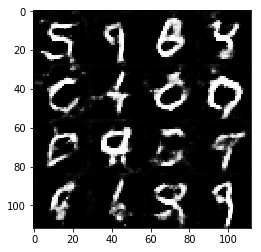

Epoch 1/2... Discriminator Loss: 1.6296... Generator Loss: 0.3379
Epoch 1/2... Discriminator Loss: 1.6339... Generator Loss: 0.3637
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.9429... Generator Loss: 1.3610
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.5740... Generator Loss: 0.3822
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.9877
Epoch 1/2... Discriminator Loss: 1.9100... Generator Loss: 2.1951


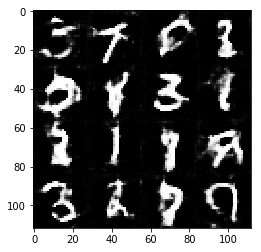

Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 1.1553
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 1.2916
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 1.2197
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.6426
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 1.0464


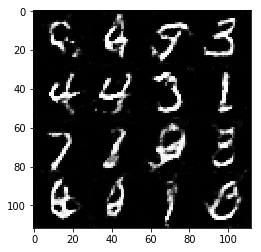

Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 1.5088
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 0.7573
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 1.3376... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 1.4805... Generator Loss: 0.4250
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.9190
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 1.1900


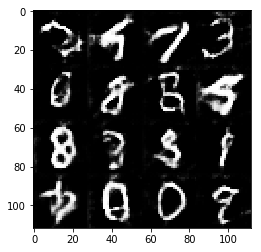

Epoch 2/2... Discriminator Loss: 1.7403... Generator Loss: 1.7388
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.6667
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 1.6387
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 2.2675... Generator Loss: 0.1699
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.7637... Generator Loss: 0.3093


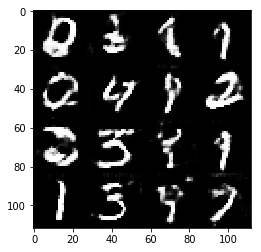

Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.9968
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 1.1933
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.9107
Epoch 2/2... Discriminator Loss: 1.9120... Generator Loss: 1.7618
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 1.4282... Generator Loss: 0.4224
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.4423


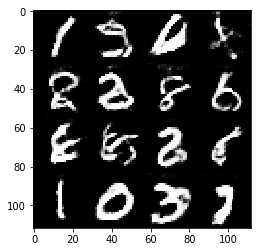

Epoch 2/2... Discriminator Loss: 1.3060... Generator Loss: 0.5110
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.5060
Epoch 2/2... Discriminator Loss: 1.6589... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.9014
Epoch 2/2... Discriminator Loss: 1.5205... Generator Loss: 1.7942
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.6762... Generator Loss: 0.3085
Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 0.5148


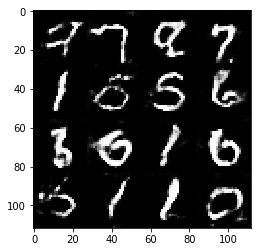

Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.4244
Epoch 2/2... Discriminator Loss: 1.2225... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 1.6810
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 0.7571
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.5520... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 0.8329
Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.4152
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.4831


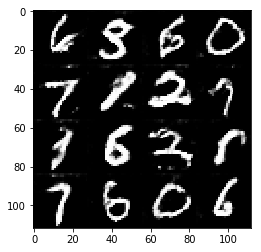

In [13]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.2



epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA


Epoch 1/1... Discriminator Loss: 3.4715... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 4.9578... Generator Loss: 6.5285
Epoch 1/1... Discriminator Loss: 1.8870... Generator Loss: 0.4420
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.8823... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.9475... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.9341... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 2.1334... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 2.0547... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 2.0133... Generator Loss: 0.9834


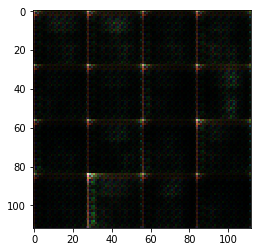

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.6835... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.6730... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.6922... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.8461... Generator Loss: 0.2934
Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 0.4382
Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.5801


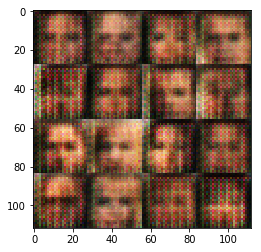

Epoch 1/1... Discriminator Loss: 1.7430... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.7305... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 2.0280... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.7901... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.7775... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 1.5096... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 1.1740


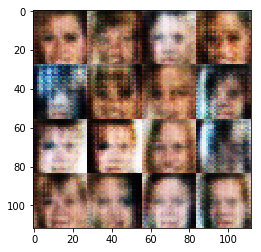

Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.9501... Generator Loss: 0.2487
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.7840... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 2.5933... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 2.1639... Generator Loss: 0.2167
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 1.0778


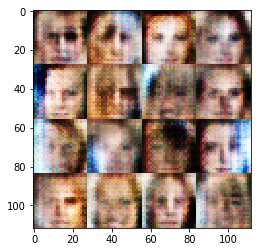

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.3820
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.3661
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5477


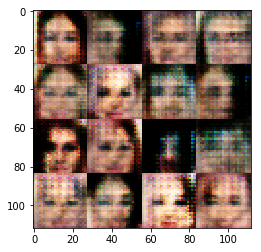

Epoch 1/1... Discriminator Loss: 2.5837... Generator Loss: 2.7974
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.7437


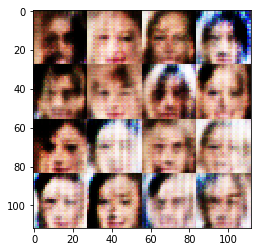

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 2.4220... Generator Loss: 2.5289
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 3.7344... Generator Loss: 2.7383
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.7396


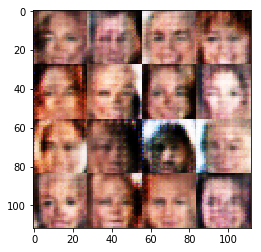

Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.3604
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.8167... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7190


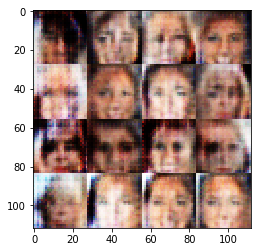

Epoch 1/1... Discriminator Loss: 1.7926... Generator Loss: 0.3089
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.7340... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 1.6800
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.6619


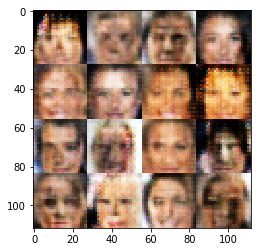

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0353


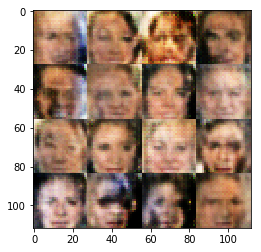

Epoch 1/1... Discriminator Loss: 1.7213... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.3255
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.4715
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6611


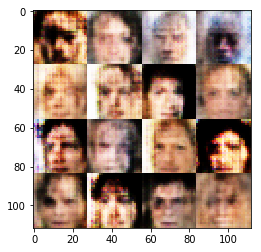

Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 1.5245
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8056


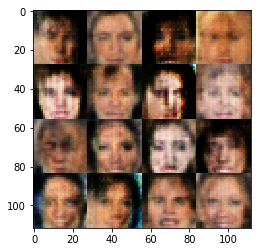

KeyboardInterrupt: 

In [16]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)